In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
from scipy.stats import multivariate_normal
from PIL import Image
import numpy as np
import random
import multiprocessing
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import neighbors
import pandas as pd
import time
from sys import stdout
import math
import quaternion
from mayavi import mlab
CPUnum=os.cpu_count()
WAY_TO_IMGS = 'C:\\Users\\Vladimir\\Desktop\\popka\\Python\\NIR\\polar_coords\\5degrees\\imgs1\\'

term = 6
number_of_angles = int(360 / term)

In [3]:
def setpriority(priority=1):
    """ Set The Priority of a Windows Process.  Priority is a value between 0-5 where
        2 is normal priority.  Default sets the priority of the current
        python process but can take any valid process ID. """

    import win32api, win32process, win32con

    priorityclasses = [win32process.IDLE_PRIORITY_CLASS,
                       win32process.BELOW_NORMAL_PRIORITY_CLASS,
                       win32process.NORMAL_PRIORITY_CLASS,
                       win32process.ABOVE_NORMAL_PRIORITY_CLASS,
                       win32process.HIGH_PRIORITY_CLASS,
                       win32process.REALTIME_PRIORITY_CLASS]

    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, priorityclasses[priority])

setpriority(5)

ModuleNotFoundError: No module named 'win32api'

In [2]:
class SOM():
    def __init__(self, dim=3,Kohonen_A=10,Kohonen_B=10,Max_val=100, sigma=None, learning_rate=0.1, 
                 neighborhood_size=None,tau1=1000,tau2=0.5, WAY_TO_IMGS=None, training_set='imgs', accuracy = 0.00001):
        np.random.seed(1234)
        if not sigma:
            sigma = dim / 2
        if not WAY_TO_IMGS:
            self.WAY_TO_IMGS = 'C:\\Users\\Vladimir\\Desktop\\popka\\Python\\NIR\\polar_coords\\5degrees\\imgs1\\'
        else: 
            self.WAY_TO_IMGS = 'C:\\Users\\Vladimir\\Desktop\\popka\\Python\\NIR\\polar_coords\\5degrees\\' + WAY_TO_IMGS + '\\'
            
        self.dim = dim
        if dim==1:
            self.shape = (Kohonen_A,Kohonen_B)
        else:
            self.shape = (Kohonen_A,Kohonen_B,dim)
        #self.Kohonen_map =  np.random.random(self.shape)*Max_val
        self.Kohonen_map = np.zeros(self.shape)
        self.Kohonen_A=Kohonen_A
        self.Kohonen_B=Kohonen_B
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.neighborhood_size = neighborhood_size
        self.xv, self.yv = np.meshgrid(np.arange(Kohonen_A), np.arange(Kohonen_B))
        self.tau1=tau1
        self.tau2=tau2
        self.history = []
        self.training_set=training_set
        self.Functional_LIST = []
        self.Eta_LIST = []
        self.sigma_LIST = []
        self.N_iter = 0 #число итераций потраченных на обучение
        self.accuracy = accuracy #минимальное значение функционала Q, на кот остановка
        self.distance_map = self.Get_Distances(self.Kohonen_A,self.Kohonen_B)
        
    def Won_Neuron(self, Vector):
        #distances = np.sqrt(((self.Kohonen_map-Vector)**2).sum(axis=-1))
        distances=np.linalg.norm(self.Kohonen_map-Vector,axis=-1)
        index=np.unravel_index(np.argmin(disutances),(self.shape[0],self.shape[1]),)
        return np.array(index)
    
    
    def Get_Distances(self,y,x):
        def ring_closure(A):
            if A==1: return [0]
            a=np.arange(A)
            max_val = int(len(a)/2)
            max_ind=np.argwhere(a==max_val)[0,0]
            if len(a)%2==0:
                b=np.arange(1,a[max_ind])[::-1]
            else:
                b=np.arange(1,a[max_ind+1])[::-1]
            a[max_ind+1:]=b
            return a
        yv=ring_closure(y)
        xv=ring_closure(x)
        XV, YV = np.meshgrid(xv, yv)
        #res = np.stack((YV,XV), axis=-1)
        res = np.sqrt(XV**2+YV**2)
        return res
    
    def Print(self):
        self.tetette=41
        print(self.Kohonen_map.shape)
        return self.Kohonen_map
    
    def FUNCTIONAL_Q(self,Vectors=None):
        Functional_Q = 0
        for i in range(len(Vectors)):
            if self.training_set=='imgs':
                N_img='img{}.png'.format(i)
                Vect = np.array(Image.open(self.WAY_TO_IMGS+N_img)).reshape(-1)
            else:
                Vect = Vectors[i]
            won_Neuron_ind = self.Won_Neuron(Vect)
            Functional_Q += ((self.Kohonen_map[won_Neuron_ind[0],won_Neuron_ind[1]]-Vect)**2).sum()
       # print(Functional_Q_last)
        return Functional_Q
    
        
    def FUNCTIONAL_Z(self,Vectors=None):
        #ATTENTION! Working only for 1D maps
        Functional_Z = 0
        for i in range(self.Kohonen_map.shape[0]):
            if i+1 == self.Kohonen_map.shape[0]:
                next_i = 0
            else:
                next_i = i+1
            Functional_Z += np.sqrt(((self.Kohonen_map[i,0,:]-self.Kohonen_map[next_i,0,:])**2).sum())
            
        return Functional_Z
    
    def FUNCTIONAL_Z1(self,Vectors=None):
        #ATTENTION! Working only for 1D maps
        A=self.Kohonen_map.reshape(-1,self.dim)
        Functional_Z = (np.sqrt(((A-np.roll(A, 1, axis=0))**2).sum(axis=-1))).sum()
        
        return Functional_Z
        
    def init_random(self, data):
        #random initialization  !!!! заменить на numpy.random.permutation  !!!!
        for i in range(self.Kohonen_A):
            n_item = np.random.randint(len(data))
            VECT = data[n_item]
            self.Kohonen_map[i,0] = np.copy(VECT)
        self.history.append(np.copy(self.Kohonen_map))
        
    def init_data_sequence(self,data):
        self.Kohonen_map = np.copy(data.reshape(self.shape))
        Functional_Q=self.FUNCTIONAL_Z(Vectors)
        self.Functional_LIST.append(Functional_Q)
    
    
    def training(self,N_iter,Vectors=None, Functional_pointer=True,Verbose=False,History_Pointer=False):
        Functional_LIST=[]
        Eta_LIST=[]
        sigma_LIST=[]
        
        if Functional_pointer:
            Functional_Q=self.FUNCTIONAL_Z(Vectors)
            Functional_LIST.append(Functional_Q)
        #print("Functional_Q0 ",Functional_Q)
        
        for n_iter in range(N_iter):
            
            n_item = np.random.randint(len(Vectors)) #max is NUM_OF_IMGS-1
            
            VECT = Vectors[n_item]
                
            won_ind = self.Won_Neuron(VECT)        #0.11 sec
            
            distances=(np.roll(self.distance_map,shift=won_ind[0], axis=0)).reshape(1,-1)
            #print(distances)
            #distances = self.Get_Distances(self.shape, won_ind)   
            #Создаем матрицу делитель, чтобы не смещать нулевые пиксели
            #check_for_null=np.copy(bias_VECT)
            #check_for_null[check_for_null>0]=1
            
            
            
            sigma = self.sigma*np.exp(-n_iter/self.tau1)
            Eta = max(self.learning_rate*np.exp(-n_iter/self.tau2),0.1)
            Kernel_G = np.exp(-distances/(2*sigma**2))
            
            #Eta=self.learning_rate
            delta1 = (VECT-self.Kohonen_map).T   #0.047
            
            self.Kohonen_map += (Eta*Kernel_G*delta1).T
            if Verbose:
                _to_print = f'\r Iters = {n_iter}, sigma = {sigma:3.4f}, Eta = {Eta:3.4f}'
                stdout.write(_to_print)
            
            #history
            if History_Pointer:
                self.history.append(np.copy(self.Kohonen_map))
            
            if Functional_pointer:
                #Functional_Q = (0.999)*Functional_Q + 0.001*((self.Kohonen_map[won_ind[0],won_ind[1]]-VECT)**2).sum()
                Functional_Q=self.FUNCTIONAL_Z(Vectors)

                self.Functional_LIST.append(Functional_Q)
                Eta_LIST.append(Eta)
                sigma_LIST.append(sigma)

                #if Functional_Q<self.accuracy:
                    #break
            
            #if n_iter % 100 == 0:
                #self.plt_saveimg(self.Kohonen_map,n_iter)
                #self.plt_saveimg(bias_VECT,n_iter)
            
            
            
        self.N_iter = n_iter
        print("FUNCTIONAL_Q ",self.FUNCTIONAL_Z(Vectors))
        print('Iters = ', n_iter, 'last sigma = ', sigma, 'last Eta = ', Eta)
        print('Kernel G', Kernel_G)
        #self.Functional_LIST=Functional_LIST
        self.Eta_LIST=Eta_LIST
        self.sigma_LIST=sigma_LIST
    
    def plt_saveimg(self,t,n_iter):
        #plt.figure(1)
        for i in range(10):
            ax1 =plt.subplot(4,5,i+1)
            b=t[i].reshape(200,200)
            plt.imshow(b)
            ax1.set_aspect('equal')

            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
            plt.axis('off')
            plt.tight_layout()
            plt.set_cmap('gray')
        plt.savefig('C:\\Users\\Vladimir\\Desktop\\popka\\Python\\NIR\\jupyter_notebook\\SOM\\som_history\\{}.png'.format(n_iter))
            

In [3]:
DATA = np.load('cube100x100_60.npy')

 Iters = 2999, sigma = 0.0997, Eta = 0.1000FUNCTIONAL_Q  141086.4173525118
Iters =  2999 last sigma =  0.0996737606761318 last Eta =  0.1
Kernel G [[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00124033e-306
  7.20514523e-285 5.18498070e-263 3.73122594e-241 2.68507211e-219
  1.93223684e-197 1.39048005e-175 1.00061997e-153 7.20068101e-132
  5.18176814e-110 3.72891412e-088 2.68340847e-066 1.93103965e-044
  1.38961853e-022 1.00000000e+000 1.38961853e-022 1.93103965e-044
  2.68340847e-066 3.72891412e-088 5.18176814e-110 7.20068101e-132
  1.00061997e-153 1.39048005e-175 1.93223684e-197 2.68507211e-219
  3.73122594e-241 5.18498070e-263 7.20514523e-285 1.00124033e-306
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e

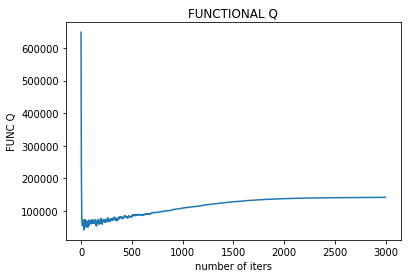

In [4]:
#test = SOM(Kohonen_A=10,Kohonen_B=1,sigma=10,dim=np.prod(shape),Max_val=255,learning_rate=0.1,tau1=1000,tau2=1000)
#дял 60 векторов - sigma=2,dim=VECTS.shape[1],learning_rate=1,tau1=1000,tau2=1000 вроде работает, но при неправильном KERNEL_G, distances должно быть **2
VECTS = DATA
test = SOM(Kohonen_A=len(VECTS),Kohonen_B=1,sigma=2,dim=VECTS.shape[1],learning_rate=1,tau1=1000,tau2=1000,training_set='VECTORS')

#test.init_data_sequence(VECTS)
test.init_random(VECTS)
#test.Kohonen_map[10,0,:] *= 0
time_start = time.time()
test.training(3000, Vectors = VECTS, Functional_pointer=True, History_Pointer=False, Verbose=True)
print(time.time() - time_start)
t=test.Functional_LIST[0:]
fig = plt.figure()
plt.title('FUNCTIONAL Q')
plt.ylabel('FUNC Q')
plt.xlabel('number of iters')
x=np.arange(len(t))
plt.plot(x, t)

In [677]:
def FUNCTIONAL_Z(data):
    #ATTENTION! Working only for 1D maps
    Functional_Z = 0
    for i in range(data.shape[0]):
        if i+1 == data.shape[0]:
            next_i = 0
        else:
            next_i = i+1
        b=np.sqrt(((data[i]-data[next_i])**2).sum())
        Functional_Z += b
        print(i, f'{b:4.2f}, max is {data[i].max()}')
        #print(f'for {Vectors[i]} and {Vectors[next_i]} FUNC = {b.sum()}')
        
    return Functional_Z
#a=FUNCTIONAL_Z(DATA)
a=FUNCTIONAL_Z(test.Kohonen_map)
print(a)


0 2588.71, max is 1705.5706322275257
1 2302.86, max is 1713.443200558152
2 2640.11, max is 1725.9663656266293
3 2168.40, max is 1741.6284633044465
4 1957.72, max is 1746.4226043804906
5 2088.45, max is 1752.1098647226852
6 1854.99, max is 1749.1681891598446
7 2420.82, max is 1738.0588598676716
8 2650.05, max is 1703.1173404731085
9 2329.15, max is 1659.6116792290604
10 2689.41, max is 1644.9018532650935
11 2817.63, max is 1633.2414833123955
12 3035.20, max is 1624.904136598238
13 3215.59, max is 1620.8662443814683
14 1721.23, max is 1617.686917069104
15 2095.86, max is 1617.686917069104
16 2180.39, max is 1617.686917069104
17 1756.75, max is 1617.686917069104
18 3515.65, max is 1620.50337655382
19 1507.40, max is 1630.4315354974829
20 1591.25, max is 1632.8772492188689
21 1741.89, max is 1636.4459185740538
22 1272.48, max is 1639.994471130947
23 3038.06, max is 1662.8882022439097
24 3304.29, max is 1651.0044221050782
25 2967.70, max is 1661.2040941515138
26 2099.68, max is 1674.4079191

In [31]:
for i in range(len(VECTS)):
    print(f'img{i} won ind=',test.Won_Neuron(VECTS[i]))

img0 won ind= [33  0]
img1 won ind= [34  0]
img2 won ind= [35  0]
img3 won ind= [36  0]
img4 won ind= [36  0]
img5 won ind= [37  0]
img6 won ind= [37  0]
img7 won ind= [38  0]
img8 won ind= [39  0]
img9 won ind= [40  0]
img10 won ind= [41  0]
img11 won ind= [41  0]
img12 won ind= [42  0]
img13 won ind= [43  0]
img14 won ind= [44  0]
img15 won ind= [45  0]
img16 won ind= [47  0]
img17 won ind= [48  0]
img18 won ind= [49  0]
img19 won ind= [50  0]
img20 won ind= [52  0]
img21 won ind= [53  0]
img22 won ind= [54  0]
img23 won ind= [55  0]
img24 won ind= [56  0]
img25 won ind= [57  0]
img26 won ind= [58  0]
img27 won ind= [59  0]
img28 won ind= [0 0]
img29 won ind= [1 0]
img30 won ind= [2 0]
img31 won ind= [3 0]
img32 won ind= [4 0]
img33 won ind= [5 0]
img34 won ind= [5 0]
img35 won ind= [6 0]
img36 won ind= [7 0]
img37 won ind= [7 0]
img38 won ind= [8 0]
img39 won ind= [9 0]
img40 won ind= [10  0]
img41 won ind= [10  0]
img42 won ind= [11  0]
img43 won ind= [12  0]
img44 won ind= [13  0]

In [680]:
@interact(i=(0,len(VECTS)-1,1))
def test_func(i):
    plt.imshow(test.Kohonen_map[i].reshape(100,100))

interactive(children=(IntSlider(value=30, description='i', max=60), Output()), _dom_classes=('widget-interact'…

In [247]:
VECTS = DATA[10:20]
a = (VECTS[0]+VECTS[-1])**0.6
VECTS = np.vstack((VECTS,a))

(60, 1, 10000)


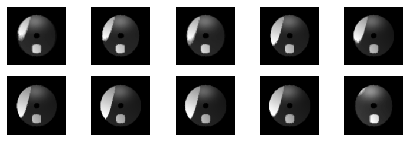

In [483]:

t=np.copy(test.Print())[10:]
#plt.figure(1)
for i in range(10):
    ax1 =plt.subplot(4,5,i+1)
    #
    b=t[i].reshape(100,100)
    plt.imshow(b)
    ax1.set_aspect('equal')

    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.axis('off')
    plt.tight_layout()
    plt.set_cmap('gray')
    #plt.figure(figsize=(20,10))
plt.savefig('TEST.png')


interactive(children=(IntSlider(value=0, description='iter_n', max=199), Output()), _dom_classes=('widget-inte…

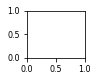

In [149]:
#see the history
@interact(iter_n=(0,199,1))
def test_func(iter_n=0):
    t=np.copy(test.history[iter_n])
    #plt.figure(1)
    for i in range(10):
        ax1 =plt.subplot(4,5,i+1)
        b=t[i].reshape(100,100)
        plt.imshow(b)
        ax1.set_aspect('equal')

        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
        plt.axis('off')
        plt.tight_layout()
        plt.set_cmap('gray')

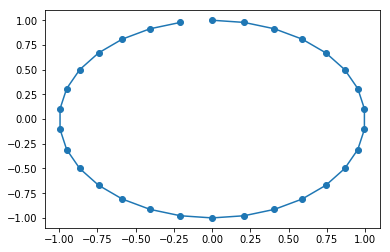

In [131]:
#КРУГ
alpha = np.linspace(0,2*np.pi,31)[:30]
x = np.sin(alpha)
y = np.cos(alpha)
Vectors = np.vstack((x,y)).T
plt.plot(x,y,'o-')
np.save('data_circle_30_1D.npy',Vectors)

In [ ]:
#КРУГ С РАНДОМОМ
data_points = []
sigma = 0.01
for _ in range(0, 1000):
    phi = np.random.rand() * np.pi * 2
    data_points.append((np.cos(phi) + np.random.normal(0, sigma), np.sin(phi) + np.random.normal(0, sigma)))

data_points = np.array(data_points)
plt.scatter(data_points[:,0], data_points[:,1])

(100, 3)
[[0.96355819 0.         0.26749883]
 [0.96161823 0.06111264 0.26749883]
 [0.95580618 0.12197919 0.26749883]
 [0.94614543 0.18235459 0.26749883]]


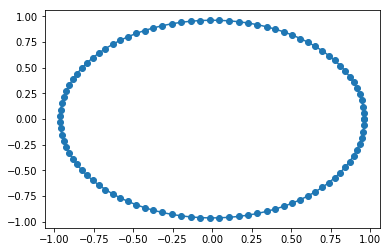

In [63]:
#сфера

thetta = np.linspace(0,np.pi,100)
phi = np.linspace(0,2*np.pi,100)
thetta = 1.3*np.ones(100)
x = np.sin(thetta)*np.cos(phi)
y = np.sin(thetta)*np.sin(phi)
z = np.cos(thetta)

Vectors = np.vstack((x,y,z)).T
plt.plot(x,y,'o-')
print(Vectors.shape)
print(Vectors[:4])

In [18]:
#TORUS
n = 200
theta = np.linspace(0, 2.*np.pi, n+1)[:n]
phi   = np.linspace(0, 2.*np.pi, n+1)[:n]
theta, phi = np.meshgrid(theta, phi)
theta = theta.reshape(-1)
phi = phi.reshape(-1)

R0, a = 1, .5

x = (R0 + a*np.cos(theta)) * np.cos(phi)
y = (R0 + a*np.cos(theta)) * np.sin(phi)
z = a * np.sin(theta)

Torus = np.vstack((x,y,z)).T + np.random.rand(n*n,3)*0.2
#np.save('data_torus_200x200_2D_1.npy',Torus)


In [19]:
#VISUALIZE
import numpy
from mayavi.mlab import *
DATA=Torus.reshape(-1,3)
def test_points3d():
    x = DATA[:,0]
    y = DATA[:,1]
    z = DATA[:,2]

    return points3d(x, y, z, colormap="copper", scale_factor=.025)

test_points3d()
show()

In [96]:
def plt_graphs(start=15,finish=-1):
    fig = plt.figure(figsize=[10,10])
    plt.subplot(4,1,1)
    plt.title('FUNCTIONAL Q')
    plt.ylabel('FUNC Q')
    plt.xlabel('number of iters')
    y=test.Functional_LIST[start:finish]
    x=np.arange(len(y))
    plt.plot(x, y)
    
    plt.subplot(4,1,2)
    y=test.Eta_LIST[start:finish]
    plt.plot(np.arange(len(y)), y)
    plt.ylabel('Eta')
    
    plt.subplot(4,1,3)
    y=test.sigma_LIST[start:finish]
    plt.plot(np.arange(len(y)), y)
    plt.ylabel('sigma')
    
    plt.subplot(4,1,4)
    a=np.copy(test.Kohonen_map)
    x=a[:,0,0]
    y=a[:,0,1]
    plt.plot(x,y,'o-')
    plt.show()

iter: 0
Iters =  100 last sigma =  35.83336541186113 last Eta =  0.8958341352965282
iter: 1000
iter: 2000
iter: 3000
iter: 4000
FUNCTIONAL_Q  6.26517488643165
Iters =  4999 last sigma =  0.1548087197419595 last Eta =  0.1
Kernel G [[1.47173185e-17 5.82301280e-19 2.30391685e-20 9.11561258e-22
  3.60665762e-23 1.42700000e-24 5.64602804e-26 2.23389156e-27
  8.83855249e-29 3.49703680e-30 1.38362774e-31 5.47442256e-33
  2.16599462e-34 8.56991336e-36 3.39074780e-37 1.34157373e-38
  5.30803287e-40 2.10016134e-41 8.30943927e-43 3.28768935e-44
  1.30079792e-45 5.14670042e-47 2.03632900e-48 8.05688202e-50
  3.18776326e-51 1.26126144e-52 4.99027152e-54 1.97443678e-55
  7.81200101e-57 3.09087433e-58 1.22292664e-59 4.83859712e-61
  1.91442572e-62 7.57456291e-64 2.99693024e-65 1.18575698e-66
  4.69153271e-68 1.85623863e-69 7.34434151e-71 1.85623863e-69
  4.69153271e-68 1.18575698e-66 2.99693024e-65 7.57456291e-64
  1.91442572e-62 4.83859712e-61 1.22292664e-59 3.09087433e-58
  7.81200101e-57 1.974436

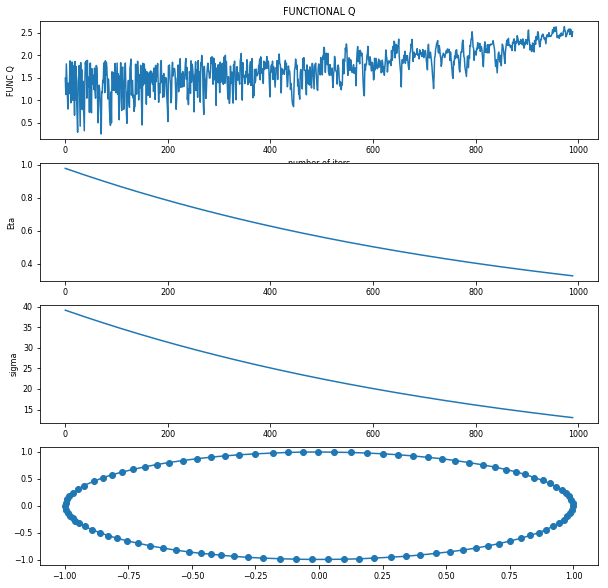

In [394]:
test = SOM(Kohonen_A=100,Kohonen_B=1,dim=2,Max_val=1,sigma=40,learning_rate=1,tau1=900,tau2=900,training_set='Vectors',accuracy = 0.000001)
#test.training1(Vectors)
test.training(5000,Vectors,History_Pointer=True)

plt_graphs(10,1000)
################################ Сделать pandas датафрейм, и по циклу протестировать работу всех переборов переменных, заодно посмотреть нагруженность ядер

interactive(children=(IntSlider(value=0, description='iter_n', max=4000), Output()), _dom_classes=('widget-int…

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

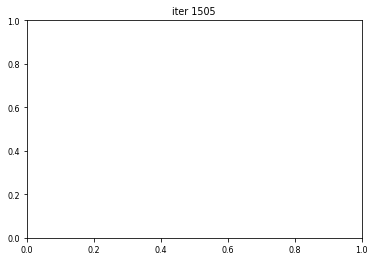

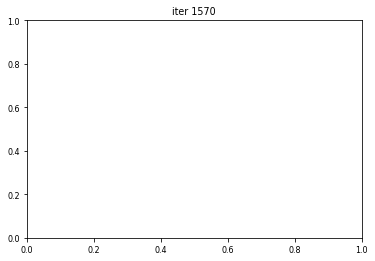

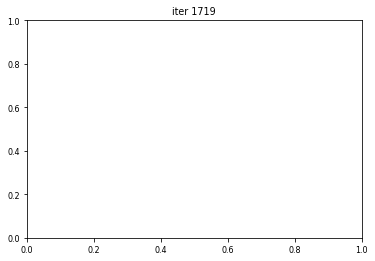

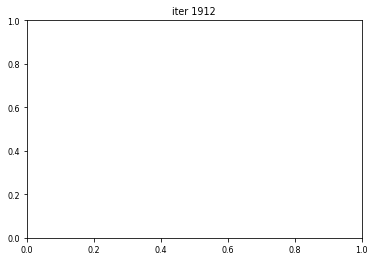

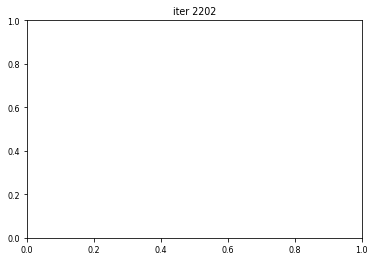

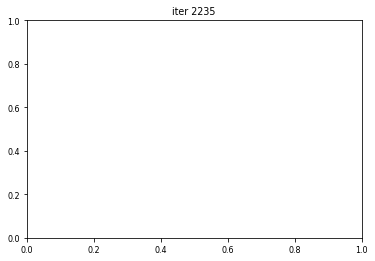

In [395]:
#see the history
@interact(iter_n=(0,4000,1))
def test_func(iter_n=0):
    plt.title(f'iter {iter_n}')
    a=np.copy(test.history[iter_n])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    x=a[:,0,0]
    y=a[:,0,1]
    plt.plot(x,y,'o-')

c:\users\vladimir\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  This is separate from the ipykernel package so we can avoid doing imports until
MovieWriter.run: running command: ['C:\\Users\\Vladimir\\Desktop\\popka\\Python\\NIR\\jupyter_notebook\\ffmpeg\\bin\\ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x400', '-pix_fmt', 'rgba', '-r', '60', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie Test', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', 'writer_test1.mp4']


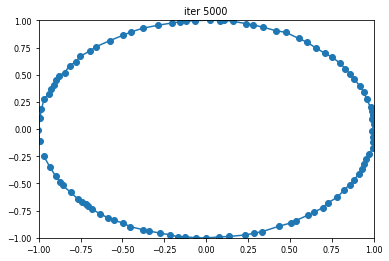

In [355]:
#Видос
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# Fixing random state for reproducibility
np.random.seed(19680801)


metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=60, metadata=metadata)

fig = plt.figure()
l, = plt.plot([], [], 'o-')

plt.xlim(-1, 1)
plt.ylim(-1, 1)


with writer.saving(fig, "writer_test1.mp4", 100):
    for i in range(100):
        plt.title(f'iter 0')
        a=np.copy(test.history[0])
        x=a[:,0,0]
        y=a[:,0,1]
        l.set_data(x, y)
        writer.grab_frame()
    for i in range(len(test.history)):
        plt.title(f'iter {i}')
        a=np.copy(test.history[i])
        x=a[:,0,0]
        y=a[:,0,1]
        l.set_data(x, y)
        writer.grab_frame()

In [167]:
a=np.copy(test.Kohonen_map)
print(test.FUNCTIONAL_Q(len(Vectors),Vectors))
test.Won_Neuron(Vectors[11])

0.13580165901991492


array([11,  0], dtype=int64)

In [77]:
#print(t.shape)
#ideal = np.copy(t[0]).reshape(100,100)
#library = 

X=np.arange(10).reshape(-1,1)
#print(X)
X = [np.zeros((3)), np.zeros(3)+1, np.zeros(3)+2, np.zeros(3)+3]

a = np.arange(4)
b = np.ones((4,4))
X=(b*a).transpose()
Y= [0, 1, 4, 9]
#Y=X**2
print(X)
print(Y)
knn = neighbors.RadiusNeighborsRegressor(weights='distance',n_neighbors=3) #radius=0.1
knn.fit(X,Y)
print(knn.predict([np.zeros(4)+2]))

[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]
[0, 1, 4, 9]
[4.]


In [160]:
DF = pd.DataFrame(columns=['sigma', 'learning_rate', 'tau1','tau2', 'Iters'])
loc_num = 0
for sigma in np.linspace(5,25,21):
    for learning_rate in np.linspace(0.1,1,20):
        for tau1 in np.linspace(50,1500,10):
            for tau2 in np.linspace(50,1500,10):
                time_st=time.time()
                test = SOM(Kohonen_A=12,Kohonen_B=1,dim=2,Max_val=1,sigma=sigma,learning_rate=learning_rate,tau1=tau1,tau2=tau2,training_set='Vectors',accuracy = 0.0000001)
                test.training(10000,len(Vectors),Vectors)
                DF.loc[loc_num] = [sigma,learning_rate,tau1,tau2,test.N_iter]
                #print(DF.loc[loc_num])
                loc_num += 1
                print(time.time()-time_st)

DF.to_csv('dataframe.csv', index=False)

      sigma  learning_rate  tau1  tau2  Iters
0 -1.403466      -1.163954   926     0      0
1  1.300609       2.117375   395     0      0
2 -0.325873      -0.746404   870     0      0
3  0.761818      -0.698728   525     0      0
4 -0.839444       1.044403   667     0      0
5 -0.366608       1.103423   663     0      0
6  0.075235      -0.906090   890     0      0
7  0.584583      -1.862961   665     0      0
8 -0.633253      -1.412774   508     0      0
9  1.118299      -1.098566   553     0      0


In [25]:
Sigma = np.linspace(1, 5, 10)
Learning_rate = np.linspace(0.8, 1, 10)
Tau1 = np.linspace(1, 60, 10)
Tau2 = np.linspace(850, 1150, 10)


def get_params(i):
    global Sigma,Learning_rate,Tau1,Tau2
    N_sigma = len(Sigma)
    N_eta = len(Learning_rate)
    N_tau1 = len(Tau1)
    N_tau2 = len(Tau2)
    
    num=i
    tau2=Tau2[num%N_tau2]
    num=num//N_tau2
    tau1=Tau1[num%N_tau1]
    num=num//N_tau1
    eta = Learning_rate[num%N_eta]
    num=num//N_eta
    sigma = Sigma[num%N_sigma]
    
    return sigma, eta, tau1,tau2
    

In [6]:
def train_SOM(i):
    global Vectors
    print(i)
    sigma, eta, tau1,tau2 = get_params(i)
    test = SOM(Kohonen_A=12,Kohonen_B=1,dim=2,Max_val=1,sigma=sigma,learning_rate=eta,tau1=tau1,tau2=tau2,training_set='Vectors',accuracy = 0.000001)
    test.training(10000,len(Vectors),Vectors)
    return test.N_iter

In [ ]:
DF = pd.DataFrame(columns=['sigma', 'learning_rate', 'tau1','tau2', 'Iters'])
if __name__ == '__main__':
    N_max=len(Sigma)*len(Learning_rate)*len(Tau1)*len(Tau2)
    print(N_max)
    with multiprocessing.Pool(processes=CPUnum) as pool:
        Training = [pool.apply_async(train_SOM, (i,)) for i in range(N_max)]
        print("JEJE")
        Numbers_of_iters = [(el.get()) for el in Training]
        a=np.array(Numbers_of_iters)
        np.save("Numbers_of_iters.npy",a)

42000
JEJE


In [26]:
b=np.load("Numbers_of_iters.npy")
print(b.argmin())
print(b.min())
get_params(3923)

3923
94


(2.333333333333333, 1.0, 14.11111111111111, 950.0)

In [79]:
import quaternion

angle = 90

angle_rad = angle/2/180*np.pi
angle_cos = np.cos(angle_rad)
angle_sin = np.sin(angle_rad)
Oz= angle_sin
qx = np.quaternion(angle_cos,angle_sin,0,0)
qz = np.quaternion(angle_cos,0,0,angle_sin)
qy = np.quaternion(angle_cos,0,angle_sin,0)

q=qy*qz


a = np.array([[0,5,0],[0,0,5]])

b=np.copy(a)
b = quaternion.rotate_vectors(qx,b)
print(b)
print(quaternion.rotate_vectors(qy,b))
print(quaternion.rotate_vectors(qy*qx,a))


a = [0.75,0,0]
MEANS = []
for i in range(6):
    a = quaternion.rotate_vectors(qz,a)
    MEANS.append(a)

x, y, z = np.mgrid[-1.0:1.0:100j, -1.0:1.0:100j, -1.0:1.0:100j]
xyz = np.column_stack([x.flat, y.flat, z.flat])

R_tor, r_tor = 0.5, 0.3
a = (x**2+y**2+z**2+R_tor**2-r_tor**2)**2 - 4*R_tor**2*(x**2+y**2)
TORUS=np.zeros(a.shape)
TORUS[a<0] = 1

[[ 0.  0.  5.]
 [ 0. -5.  0.]]
[[ 5.  0.  0.]
 [ 0. -5.  0.]]
[[ 5.  0.  0.]
 [ 0. -5.  0.]]


In [90]:
a = np.array([1,0,0])
angle = 180
angle_rad = angle/2/180*np.pi
angle_cos = np.cos(angle_rad)
angle_sin = np.sin(angle_rad)

qx = np.quaternion(angle_cos,angle_sin,0,0)
qy = np.quaternion(angle_cos,0,angle_sin,0)

b = quaternion.rotate_vectors(qy,a)
print(b)

[-1.0000000e+00  0.0000000e+00 -1.2246468e-16]


In [2]:
x, y, z = np.mgrid[-1.0:1.0:750j, -1.0:1.0:750j, -1.0:1.0:750j]

KeyboardInterrupt: 

 29 done  379.03762525537877


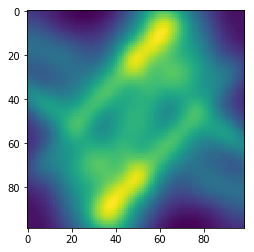

In [7]:
#Generate gaussians in 3D

x, y, z = np.mgrid[-1.0:1.0:99j, -1.0:1.0:99j, -1.0:1.0:99j]
xyz = np.column_stack([x.flat, y.flat, z.flat])

#R_tor, r_tor = 0.5, 0.3
#a = (x**2+y**2+z**2+R_tor**2-r_tor**2)**2 - 4*R_tor**2*(x**2+y**2)  #TORUS
#a = x**2+y**2+z**2
#SPHERE=np.zeros(a.shape)
#SPHERE[a<0.98] = 1

z=np.zeros(99*99*99)
for i in range(30):
    #get Positive semi-definite COV matrix
    A = np.random.randn(3,3)
    COV = np.dot(A,A.transpose())
    COV=np.linalg.inv(COV)/10
    Mean=((np.random.rand(3))*2-1)*0.75
    Height = np.random.randint(100)
    S = multivariate_normal.pdf(xyz, mean=Mean,cov=COV)
    S *= np.sqrt(np.linalg.det(COV)*(2*np.pi)**3)  #normalize to 1(formulae Gauss)
    z+= S*Height
    
    S = multivariate_normal.pdf(xyz, mean=-1*Mean,cov=COV)
    S *= np.sqrt(np.linalg.det(COV)*(2*np.pi)**3)  #normalize to 1(formulae Gauss)
    z+= S*Height
    stdout.write(f'\r {i} done')
z = z.reshape((99,99,99))# * SPHERE
print(' ',z.max())
plt.imshow(z[:,:,49])

 29 done  491.7757908179665


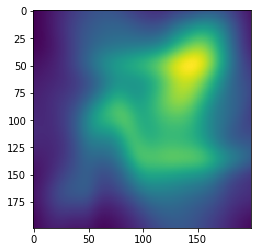

In [25]:
#Generate gaussians in 3D

x, y, z = np.mgrid[-1.0:1.0:199j, -1.0:1.0:199j, -1.0:1.0:199j]
xyz = np.column_stack([x.flat, y.flat, z.flat])

#R_tor, r_tor = 0.5, 0.3
#a = (x**2+y**2+z**2+R_tor**2-r_tor**2)**2 - 4*R_tor**2*(x**2+y**2)  #TORUS
#a = x**2+y**2+z**2
#SPHERE=np.zeros(a.shape)
#SPHERE[a<0.98] = 1

z=np.zeros(199*199*199)
for i in range(30):
    #get Positive semi-definite COV matrix
    A = np.random.randn(3,3)
    COV = np.dot(A,A.transpose())
    COV=np.linalg.inv(COV)/10
    Mean=((np.random.rand(3))*2-1)*0.75
    Height = np.random.randint(100)
    S = multivariate_normal.pdf(xyz, mean=Mean,cov=COV)
    S *= np.sqrt(np.linalg.det(COV)*(2*np.pi)**3)  #normalize to 1(formulae Gauss)
    z+= S*Height
    
    S = multivariate_normal.pdf(xyz, mean=-1*Mean,cov=COV)
    S *= np.sqrt(np.linalg.det(COV)*(2*np.pi)**3)  #normalize to 1(formulae Gauss)
    z+= S*Height
    stdout.write(f'\r {i} done')
z = z.reshape((199,199,199))# * SPHERE
print(' ',z.max())
plt.imshow(z[:,:,99])

 99 done  -85.749534353359


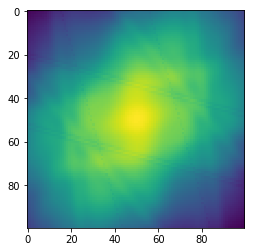

In [394]:
#Generate Mexicans_HAT in 3D
x, y, z = np.mgrid[-1.0:1.0:100j, -1.0:1.0:100j, -1.0:1.0:100j]
xyz = np.column_stack([x.flat, y.flat, z.flat])

def Mexican_HAT(Mean,COV):
    coords = xyz - Mean
    A=coords.reshape(len(coords),1,3)
    B=coords.reshape(len(coords),3,1)

    res=(A@ COV@ B).reshape(-1)/2
    f = np.exp(-res)
    f *= (1-15*res)
    return f

z=np.zeros(100*100*100)
for i in range(10):
    Mean=((np.random.rand(3))*2-1)*0.75
    #Height = np.random.randint(100)
    Height=1
    A = np.random.randn(3,3)
    COV = np.dot(A,A.transpose())
    COV=np.linalg.inv(COV)/10
    z+= Mexican_HAT(Mean,COV)*Height
    
    z+= Mexican_HAT(-1*Mean,COV)*Height
    stdout.write(f'\r {i} done')
z = z.reshape((100,100,100))# * SPHERE
print(' ',z.max())
plt.imshow(z[:,:,49])

In [26]:
#show slices with Mayavi
import numpy as np
from mayavi.mlab import *

def test_volume_slice():
    x, y, z = np.ogrid[-5:5:64j, -5:5:64j, -5:5:64j]

    scalars = x * x * 0.5 + y * y + z * z * 2.0

    obj = volume_slice(scalars, plane_orientation='z_axes')
    return obj

#test_volume_slice()
#volume_slice(SPHERE, plane_orientation='z_axes')
volume_slice(z, plane_orientation='x_axes')
volume_slice(z, plane_orientation='z_axes')
volume_slice(z, plane_orientation='y_axes')
show()

In [27]:
np.save('DENSITY10.npy',z)

In [18]:
#create X plane 
import numpy as np
WIDTH = 99

X_plane = np.mgrid[:WIDTH, :WIDTH].reshape(2,-1).T
X_plane = np.hstack((int(WIDTH/2)*np.ones((X_plane.shape[0], 1)),X_plane))
X_plane -= int(WIDTH/2)
#
#Density_matrix = np.load('DENSITY_Frenel.npy')
#Density_matrix = np.load('DENSITY_Non_Fredel.npy')
Density_matrix = np.load('DENSITY9.npy')

Density_coords = np.mgrid[:WIDTH, :WIDTH, :WIDTH].reshape(3,-1).T - int(WIDTH/2)
#Density_coords = np.mgrid[:150, :150, :150].reshape(3,-1).T - int(150/2)

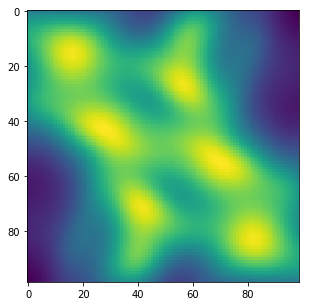

In [19]:
#knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn = neighbors.RadiusNeighborsRegressor(radius=1.2, weights='distance')
Y = Density_matrix.reshape(-1)
X = Density_coords

knn.fit(X, Y)
    
def Get_slice(coords):
    output = knn.predict(coords)
    return output.reshape((WIDTH,WIDTH))

def Get_slice1(new_coords):
    knn.fit(new_coords, Y)
    output = knn.predict(X_plane)
    return output.reshape((WIDTH,WIDTH))

    
a=Get_slice(X_plane)
plt.figure(figsize=(5,5))
plt.imshow(a)

In [18]:
import numpy
from mayavi.mlab import *

def test_points3d():
    dd=DATA.reshape(-1,3)
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    plot3d(x, y, z, np.arange(len(x)), tube_radius=0.025, colormap='Spectral')
    #return points3d(x, y, z, colormap="copper", scale_factor=.1)

test_points3d()
show()

In [5]:
#плоскость с вектором нормали
normal=np.stack((np.arange(50),np.zeros(50),np.zeros(50))).T
normal.shape

(50, 3)

In [43]:
angle_z = 90
angle_y = 90
angle_cos_y = np.cos(angle_y/2/180*np.pi)
angle_sin_y = np.sin(angle_y/2/180*np.pi)

angle_cos_z = np.cos(angle_z/2/180*np.pi)
angle_sin_z = np.sin(angle_z/2/180*np.pi)

qz = np.quaternion(angle_cos_z,0,0,angle_sin_z)
qy = np.quaternion(angle_cos_y,0,angle_sin_y,0)
qx = np.quaternion(angle_cos_z,angle_sin_z,0,0)

quaternion.as_euler_angles(qx*qy)/np.pi*180
#QN= quaternion.from_euler_angles(0.3*np.pi,0,0)
#print(QN)

array([ 0., 90., 90.])

In [77]:
X_plane.T

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [-50., -50., -50., ...,  49.,  49.,  49.],
       [-50., -49., -48., ...,  47.,  48.,  49.]])

In [20]:
def R_z(angle):
    a=angle/180*np.pi
    res = np.array([[np.cos(a),-np.sin(a),0],
                    [np.sin(a),np.cos(a),0],
                    [0,0,1]])
    return res

def R_x(angle):
    a=angle/180*np.pi
    res = np.array([[1,0,0],
                    [0,np.cos(a),-np.sin(a)],
                    [0,np.sin(a),np.cos(a)]])
    return res

def R_y(angle):
    a=angle/180*np.pi
    res = np.array([[np.cos(a),0,np.sin(a)],
                    [0,1,0],
                    [-np.sin(a),0,np.cos(a)]])
    return res

def Quatern(axis='x',angle=0):
    _angle= angle/2/180*np.pi
    _cos,_sin = np.cos(_angle),np.sin(_angle)
    if type(axis)==str:
        if axis=='x':
            _vect = [1,0,0]
        elif axis=='y':
            _vect = [0,1,0]
        elif axis=='z':
            _vect = [0,0,1]
    else:
        _vect = axis
    return np.quaternion(_cos,_sin*_vect[0],_sin*_vect[1],_sin*_vect[2])

a=np.array([[0,5,0],[5,0,0]])
rot_matrix_res = R_z(48)@R_y(48)@X_plane.T
rot_matrix_res.shape

(3, 9801)

In [299]:
a=np.array([[0,5,0],[5,0,0]])
qua = Quatern(axis=[2,0,0],_angle=90)
b = quaternion.rotate_vectors(qua,a)
b

array([[ 0., -3.,  4.],
       [ 5.,  0.,  0.]])

In [257]:
#проверка с матрицами вращения
alpha0 = R_y(34)@R_z(48)@X_plane.T #red
alpha1 = R_y(34)@R_z(48+180)@X_plane.T #blue
test_points3d(1)
alpha0 = R_y(34)@R_z(48)@X_plane.T #red
alpha1 = R_y(34+180)@R_z(48)@X_plane.T #blue
test_points3d(2)

alpha0 = R_y(34)@R_x(48)@X_plane.T #red
alpha1 = R_y(34)@R_x(48+180)@X_plane.T #blue
test_points3d(3)
alpha0 = R_y(34)@R_x(48)@X_plane.T #red
alpha1 = R_y(34+180)@R_x(48)@X_plane.T #blue
test_points3d(4)

alpha0 = R_z(34)@R_x(48)@X_plane.T #red
alpha1 = R_z(34)@R_x(48+180)@X_plane.T #blue
test_points3d(5)
alpha0 = R_z(34)@R_x(48)@X_plane.T #red
alpha1 = R_z(34+180)@R_x(48)@X_plane.T #blue
test_points3d(6)

alpha0 = R_z(34)@R_y(48)@X_plane.T #red
alpha1 = R_z(34)@R_y(48+180)@X_plane.T #blue
test_points3d(7)
alpha0 = R_z(34)@R_y(48)@X_plane.T #red
alpha1 = R_z(34+180)@R_y(48)@X_plane.T #blue
test_points3d(8)

alpha0 = R_x(34)@R_z(48)@X_plane.T #red
alpha1 = R_x(34)@R_z(48+180)@X_plane.T #blue
test_points3d(9)
alpha0 = R_x(34)@R_z(48)@X_plane.T #red
alpha1 = R_x(34+180)@R_z(48)@X_plane.T #blue
test_points3d(10)

alpha0 = R_x(34)@R_y(48)@X_plane.T #red
alpha1 = R_x(34)@R_y(48+180)@X_plane.T #blue
test_points3d(11)
alpha0 = R_x(34)@R_y(48)@X_plane.T #red
alpha1 = R_x(34+180)@R_y(48)@X_plane.T #blue
test_points3d(12)

show()

In [407]:


q1 = Quatern(axis='z',angle=35)
tst = quaternion.rotate_vectors(q1,X_plane)
vx = quaternion.rotate_vectors(q1,np.array([1,0,0]))

q2 = Quatern(axis=vx,angle=56)
alpha0 = quaternion.rotate_vectors(q2,tst).T

q2 = Quatern(axis=vx,angle=56+15)
alpha1 = quaternion.rotate_vectors(q2,tst).T
print(alpha0.shape)
test_points3d(0,SHOW=True)

(3, 9801)


In [382]:
tst = R_x(34)@R_z(48)@X_plane.T
alpha0 = R_x(34)@R_z(48+180)@X_plane.T
alpha1 = (tst.T * [-1,-1,-1]).T
print(tst.T[:2])
print(alpha0.T[97:99])
print(alpha1.T[:2])
test_points3d(0,SHOW=True)


[[ 36.41409645   0.218466   -58.9573223 ]
 [ 36.41409645  -0.3407269  -58.12828472]]
[[-36.41409645   0.3407269   58.12828472]
 [-36.41409645  -0.218466    58.9573223 ]]
[[-36.41409645  -0.218466    58.9573223 ]
 [-36.41409645   0.3407269   58.12828472]]


In [401]:
import numpy
from mayavi.mlab import *

def test_points3d(num=0,SHOW=False):
    mlab.clf() # clear the figure (to reset the colors)
    dd = alpha0
    x,y,z = dd[0],dd[1],dd[2]
    plot3d(x, y, z, np.arange(len(x)), tube_radius=0.725, colormap='Spectral')
    #points3d(x, y, z, color = (1,0,0), scale_factor=1)
    dd = alpha1
    x,y,z = dd[0],dd[1],dd[2]
    plot3d(x, y, z, np.arange(len(x)), tube_radius=0.725, colormap='Spectral')
    #points3d(x, y, z, color = (0,0,1), scale_factor=1)
    if SHOW ==True:
        show()
    else:
        f = mlab.gcf()
        f.scene._lift()
        a=mlab.screenshot(antialiased=True)
        plt.imsave(f'test{num}.png',a)
test_points3d(0,SHOW=True)
#show()

In [160]:

#Generate rotated slices 1D
import quaternion
import numpy as np
Data = []
X_planes = []
norms = []
num_of_z = 360

for z in range(num_of_z):
    angle_z= 360/num_of_z*z
    q1 = Quatern(axis='z',angle=angle_z)
    tst = quaternion.rotate_vectors(q1,X_plane)
    img = Get_slice(tst)
    Data.append(img)
        #normal_new = quaternion.rotate_vectors(qy*qz,normal)
        #norms.append(normal_new)
        #X_planes.append(X_plane_new)
        
    _to_print = f'\r {z} slice done'
    stdout.write(_to_print)

 359 slice done

In [13]:
from skimage.transform import rotate
import quaternion
import numpy as np
Data = []
X_planes = []
norms = []
num_of_x = 60
num_of_z = 60
for z in range(num_of_z):
    angle_z= 360/num_of_z*z
    q1 = Quatern(axis=[0,0,1],angle=angle_z)
    tst = quaternion.rotate_vectors(q1,X_plane)
    img = Get_slice(tst)
    for x in range(num_of_x):
        angle_x = 180/num_of_x*x
        A = img.reshape(99,99)
        B = rotate(A,angle_x)
        Data.append(B)
        _to_print = f'\r {angle_z} {angle_x} slice done'
        stdout.write(_to_print)

 354.0 177.0 slice done

In [21]:
#                                           TRUE
#Generate rotated slices 2D
import quaternion
import numpy as np
Data = []
X_planes = []
norms = []
num_of_x = 10
num_of_z = 10
for z in range(num_of_z):
    angle_z= 360/num_of_z*z
    q1 = Quatern(axis='z',angle=angle_z)
    tst = quaternion.rotate_vectors(q1,X_plane)
    vx = quaternion.rotate_vectors(q1,np.array([1,0,0]))

    for x in range(num_of_x):
        angle_x = 180/num_of_x*x
        q2 = Quatern(axis=vx,angle=angle_x)
        #q2 = Quatern(axis='x',angle=angle_x)
        
        X_plane_new = quaternion.rotate_vectors(q2,tst)
        img = Get_slice(X_plane_new)
        Data.append(img)
        #normal_new = quaternion.rotate_vectors(qy*qz,normal)
        #norms.append(normal_new)
        #X_planes.append(X_plane_new)
        
        _to_print = f'\r {angle_z} {angle_x} slice done'
        stdout.write(_to_print)

 0.0 0.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 0.0 slice donee

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 0.0 slice donee

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 0.0 slice donene

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


In [144]:
#                                           TRUEasdfasdf
#Generate rotated slices 2D
import quaternion
import numpy as np
Data = []
X_planes = []
norms = []
num_of_x = 10
num_of_z = 10
for x in range(num_of_z):
    for z in range(num_of_x):
        angle_x = 180/num_of_x*x
        q1 = Quatern(axis='x',angle=angle_x)
        tst = quaternion.rotate_vectors(q1,X_plane)
        
        vz = quaternion.rotate_vectors(q1,np.array([0,0,1]))
        angle_z= 360/num_of_z*z
        q2 = Quatern(axis=vz,angle=angle_z)
        #q2 = Quatern(axis='z',angle=angle_z)
        
        X_plane_new = quaternion.rotate_vectors(q2,tst)
        img = Get_slice(X_plane_new)
        Data.append(img)
        #normal_new = quaternion.rotate_vectors(qy*qz,normal)
        #norms.append(normal_new)
        #X_planes.append(X_plane_new)
        
        _to_print = f'\r {angle_z} {angle_x} slice done'
        stdout.write(_to_print)

 324.0 0.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 18.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 36.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 54.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 72.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 90.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 108.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 126.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 0.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 288.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 144.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 36.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 72.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 108.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 144.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 180.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 216.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 252.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


 324.0 162.0 slice done

c:\python37\lib\site-packages\sklearn\neighbors\regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


In [102]:
#a=np.array(norms)
#print(a.shape)
#test=np.swapaxes(np.array(norms)[:,-1].reshape(60,60,3),0,1).reshape(-1,3)
test=np.array(norms)[:,-1]
print(test.shape)
#print(test[1800:1810])

(100, 50)


In [106]:
import numpy
from mayavi.mlab import *

def test_points3d():
    dd=X_planes[0].T
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    plot3d(x, y, z, np.arange(len(x)), tube_radius=1.025, colormap='Spectral')
    #return points3d(x, y, z, colormap="copper", scale_factor=.1)

test_points3d()
show()

In [149]:
#плоскость режущая кубик
X_planesS=np.array(X_planes)
NORMS=np.array(norms)
print(X_planesS.shape,NORMS.shape)

x, y, z=X_planesS[0].T
#plane0=mlab.points3d(x,y,z,color=(1,0,0),scale_factor=1)
plane0=mlab.plot3d(x, y, z, np.arange(len(x)), tube_radius=1.025, colormap='Spectral')
x, y, z=NORMS[0].T
norm_vect0 = mlab.points3d(x,y,z,color=(1,1,0), scale_factor=2)
#WIDTH=100
#cube=np.mgrid[:WIDTH, :WIDTH, :WIDTH].reshape(3,-1).T - int(WIDTH/2)
#x, y, z=cube.T
#cubee= mlab.points3d(x,y,z,color=(1,1,1), scale_factor=1)
@mlab.show
@mlab.animate(delay=1000)
def anim():
    while True:
        for i in range(60):
            #stdout.write(f'\r {i}')
            x, y, z = X_planesS[i].T
            plane0.mlab_source.trait_set(x=x,y=y,z=z)
            #plane1=mlab.points3d(x,y,z,scale_factor=1)
            x, y, z=NORMS[i].T
            norm_vect0.mlab_source.trait_set(x=x,y=y,z=z)
            yield
anim()

(100, 10000, 3) (100, 50, 3)


In [95]:
x,y,=10,10
X_planesS=np.swapaxes(np.array(X_planes),1,2).reshape(x,y,3,-1)
NORMS=np.swapaxes(np.array(norms),1,2).reshape(x,y,3,-1)

x0,y0=0,0
x1,y1=0,0
x, y, z=X_planesS[x0,y0]
plane0=mlab.points3d(x,y,z,color=(1,0,0),scale_factor=1)

x, y, z=NORMS[x0,y0]
norm_vect0= mlab.points3d(x,y,z,color=(1,0,0), scale_factor=2)
    
x, y, z=X_planesS[x1,y1]
plane1=mlab.points3d(x,y,z,scale_factor=1)
plane1.glyph.scale_mode = 'scale_by_vector'
plane1.mlab_source.dataset.point_data.scalars = np.linspace(0,1,10000)

x, y, z=NORMS[x1,y1]
norm_vect1= mlab.points3d(x,y,z,color=(0,0,1), scale_factor=2)

@mlab.show
@mlab.animate(delay=10)
def anim():
    while True:
        for i in range(60):
            #stdout.write(f'\r {i}')
            x, y, z = X_planesS[x1,i]
            plane1.mlab_source.trait_set(x=x,y=y,z=z)
            #plane1=mlab.points3d(x,y,z,scale_factor=1)
            x, y, z=NORMS[x1,i]
            norm_vect1.mlab_source.trait_set(x=x,y=y,z=z)
            yield
anim()

AxisError: axis1: axis 1 is out of bounds for array of dimension 1

In [100]:
len(X_planes)
len(norms)

100

In [21]:
#видосик
import numpy as np
import mayavi.mlab as mlab
import moviepy.editor as mpy
duration= 6 # duration of the animation in seconds (it will loop)

# MAKE A FIGURE WITH MAYAVI

fig_myv = mlab.figure(size=(520,520), bgcolor=(1,1,1))
X_planesS=np.swapaxes(np.array(X_planes),1,2).reshape(60,60,3,-1)
NORMS=np.swapaxes(np.array(norms),1,2).reshape(60,60,3,-1)
LINE=np.array(norms)[:,-1].T
# ANIMATE THE FIGURE WITH MOVIEPY, WRITE AN ANIMATED GIF
i=0
def make_frame(t):
    global i
    mlab.clf() # clear the figure (to reset the colors)

    x, y, z=X_planesS[x0,y0]
    plane0=mlab.points3d(x,y,z,color=(1,0,0),scale_factor=1)

    x, y, z=NORMS[x0,y0]
    norm_vect0= mlab.points3d(x,y,z,color=(1,0,0), scale_factor=2)

    x, y, z=X_planesS[x1,i]
    plane1=mlab.points3d(x,y,z,scale_factor=1)
    plane1.glyph.scale_mode = 'scale_by_vector'
    plane1.mlab_source.dataset.point_data.scalars = np.linspace(0,1,10000)
    x, y, z=NORMS[x1,i]
    norm_vect1= mlab.points3d(x,y,z,color=(0,0,1), scale_factor=2)
    
    i+=1
    f = mlab.gcf()
    f.scene._lift()
    mlab.view(distance=270)
    return mlab.screenshot(antialiased=True)

animation = mpy.VideoClip(make_frame, duration=duration)
animation.write_videofile("wireframe1.mp4", fps=10)
#animation.write_gif("wireframe1.gif", fps=60)
mlab.show()

Moviepy - Building video wireframe1.mp4.


t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [12:06<00:00,  1.55it/s, now=None]
                                                                                                                       


Moviepy - Writing video wireframe1.mp4



t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [04:18<00:00,  1.51it/s, now=None]

t:   0%|                                                                              | 0/60 [00:00<?, ?it/s, now=None]

t:   3%|██▎                                                                   | 2/60 [00:00<00:20,  2.83it/s, now=None]

t:   5%|███▌                                                                  | 3/60 [00:01<00:25,  2.23it/s, now=None]

t:   7%|████▋                                                                 | 4/60 [00:02<00:28,  1.94it/s, now=None]

t:   8%|█████▊                                                                | 5/60 [00:02<00:30,  1.78it/s, now=None]

t:  10%|███████                                                               | 6/60 [00:03<00:31,  1.70it/s, now=None]

t:  12%|████████▏                                                             | 7/60 [00:04<00:32,  1.64it/s, now=None]

t:  13%|█████████▎              

IndexError: index 60 is out of bounds for axis 1 with size 60

In [542]:

#animate history
import numpy as np
from mayavi import mlab



X_planesS=np.swapaxes(np.array(X_planes),1,2)
x, y, z=X_planesS[0]
nodes=mlab.points3d(x,y,z,scale_factor=1)
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = np.hstack((np.ones(5000),np.zeros(5000)))

NORMS=np.swapaxes(np.array(norms),1,2)
x, y, z=NORMS[0]
norm_vect= mlab.points3d(x,y,z,color=(0,0,0), scale_factor=2)

LINE=np.array(norms)[:,-1].T
x, y, z = LINE[:,:3]
print(x, y, z)
line=mlab.plot3d(x, y, z,np.arange(len(x)), tube_radius=0.725, colormap='Spectral')
#mlab.axes()
@mlab.show
@mlab.animate(delay=10)
def anim():
    while True:
        for i in range(3,len(X_planes)):
            #stdout.write(f'\r {i}')
            x, y, z = X_planesS[i]
            nodes.mlab_source.trait_set(x=x,y=y,z=z)
            x, y, z = NORMS[i]
            norm_vect.mlab_source.trait_set(x=x,y=y,z=z)
            x, y, z = LINE[:,:i]
            line.mlab_source.reset(x=x,y=y,z=z,scalars=np.arange(len(x)))
            yield
anim()
#mlab.show()

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [0. 1.], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError


[49. 49. 49.] [0. 0. 0.] [0. 0. 0.]


Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [0. 1.], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Ex

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
Asser

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [0. 1.], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Ex

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
Asser

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
Asser

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [0. 1.], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Ex

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
Asser

Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C91F82C048>, trait: data_range, old value: [ 1.e+299 -1.e+299], new value: [ 1.e+299 -1.e+299]
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\traits\trait_notifiers.py", line 394, in __call__
    self.handler(*args)
  File "c:\python37\lib\site-packages\mayavi\core\lut_manager.py", line 433, in _data_range_changed
    assert value[0] <= value[1]
AssertionError


In [22]:
#видосик
import numpy as np
import mayavi.mlab as mlab
import moviepy.editor as mpy
duration= 10 # duration of the animation in seconds (it will loop)

# MAKE A FIGURE WITH MAYAVI

fig_myv = mlab.figure(size=(520,520), bgcolor=(1,1,1))
X_planesS=np.swapaxes(np.array(X_planes),1,2)
colors=np.hstack((np.ones(5000),np.zeros(5000)))
NORMS=np.swapaxes(np.array(norms),1,2)
LINE=np.array(norms)[:,-1].T
# ANIMATE THE FIGURE WITH MOVIEPY, WRITE AN ANIMATED GIF
i=1700
def make_frame(t):
    global i
    mlab.clf() # clear the figure (to reset the colors)
    
    x, y, z=X_planesS[i]
    nodes=mlab.points3d(x,y,z,scale_factor=1, figure=fig_myv)
    nodes.glyph.scale_mode = 'scale_by_vector'
    nodes.mlab_source.dataset.point_data.scalars = colors
    
    x, y, z=NORMS[i]
    mlab.points3d(x,y,z,color=(0,0,0), scale_factor=2, figure=fig_myv)

    x, y, z = LINE[:,:i]
    mlab.plot3d(x, y, z,np.arange(len(x)), tube_radius=0.725, colormap='Spectral', figure=fig_myv)
    
    i+=1
    f = mlab.gcf()
    f.scene._lift()
    mlab.view(distance=270)
    return mlab.screenshot(antialiased=True)

animation = mpy.VideoClip(make_frame, duration=duration)
animation.write_videofile("wireframe1.mp4", fps=60)
#animation.write_gif("wireframe1.gif", fps=60)
mlab.show()

Moviepy - Building video wireframe1.mp4.


t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [22:36<00:00,  1.51it/s, now=None]

                                                                                                                       
                                                                                                                       



Moviepy - Writing video wireframe1.mp4



t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [22:36<00:00,  1.51it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [18:18<00:00,  1.51it/s, now=None]


t:   0%|                                                                             | 0/600 [00:00<?, ?it/s, now=None]


t:   0%|▏                                                                    | 2/600 [00:00<02:08,  4.64it/s, now=None]


t:   0%|▎                                                                    | 3/600 [00:00<02:48,  3.53it/s, now=None]


t:   1%|▍                                                                    | 4/600 [00:01<03:16,  3.03it/s, now=None]


t:   1%|▌                                                                    | 5/600 [00:01<03:35,  2.76it/s, now=None]


t:   1%|▋                                                                    | 6/600 [00:02<03:48,  2.60it/s, now=None]


t:   1%|▊                

t:  22%|██████████████▋                                                    | 132/600 [00:55<03:17,  2.37it/s, now=None]


t:  22%|██████████████▊                                                    | 133/600 [00:55<03:16,  2.37it/s, now=None]


t:  22%|██████████████▉                                                    | 134/600 [00:56<03:15,  2.38it/s, now=None]


t:  22%|███████████████                                                    | 135/600 [00:56<03:15,  2.38it/s, now=None]


t:  23%|███████████████▏                                                   | 136/600 [00:57<03:15,  2.38it/s, now=None]


t:  23%|███████████████▎                                                   | 137/600 [00:57<03:16,  2.36it/s, now=None]


t:  23%|███████████████▍                                                   | 138/600 [00:57<03:17,  2.34it/s, now=None]


t:  23%|███████████████▌                                                   | 139/600 [00:58<03:20,  2.30it/s, now=None]


t:  23%|███████████████▋

t:  44%|█████████████████████████████▋                                     | 266/600 [01:51<02:21,  2.36it/s, now=None]


t:  44%|█████████████████████████████▊                                     | 267/600 [01:52<02:20,  2.37it/s, now=None]


t:  45%|█████████████████████████████▉                                     | 268/600 [01:52<02:19,  2.37it/s, now=None]


t:  45%|██████████████████████████████                                     | 269/600 [01:53<02:19,  2.37it/s, now=None]


t:  45%|██████████████████████████████▏                                    | 270/600 [01:53<02:19,  2.37it/s, now=None]


t:  45%|██████████████████████████████▎                                    | 271/600 [01:53<02:18,  2.37it/s, now=None]


t:  45%|██████████████████████████████▎                                    | 272/600 [01:54<02:18,  2.37it/s, now=None]


t:  46%|██████████████████████████████▍                                    | 273/600 [01:54<02:18,  2.37it/s, now=None]


t:  46%|████████████████

t:  67%|████████████████████████████████████████████▋                      | 400/600 [02:48<01:22,  2.41it/s, now=None]


t:  67%|████████████████████████████████████████████▊                      | 401/600 [02:48<01:22,  2.41it/s, now=None]


t:  67%|████████████████████████████████████████████▉                      | 402/600 [02:48<01:22,  2.40it/s, now=None]


t:  67%|█████████████████████████████████████████████                      | 403/600 [02:49<01:21,  2.41it/s, now=None]


t:  67%|█████████████████████████████████████████████                      | 404/600 [02:49<01:21,  2.41it/s, now=None]


t:  68%|█████████████████████████████████████████████▏                     | 405/600 [02:50<01:21,  2.41it/s, now=None]


t:  68%|█████████████████████████████████████████████▎                     | 406/600 [02:50<01:20,  2.41it/s, now=None]


t:  68%|█████████████████████████████████████████████▍                     | 407/600 [02:51<01:20,  2.41it/s, now=None]


t:  68%|████████████████

t:  89%|███████████████████████████████████████████████████████████▋       | 534/600 [03:43<00:27,  2.42it/s, now=None]


t:  89%|███████████████████████████████████████████████████████████▋       | 535/600 [03:44<00:26,  2.42it/s, now=None]


t:  89%|███████████████████████████████████████████████████████████▊       | 536/600 [03:44<00:26,  2.42it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████▉       | 537/600 [03:45<00:26,  2.42it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████       | 538/600 [03:45<00:25,  2.42it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████▏      | 539/600 [03:46<00:25,  2.42it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████▎      | 540/600 [03:46<00:24,  2.42it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████▍      | 541/600 [03:46<00:24,  2.42it/s, now=None]


t:  90%|████████████████

Moviepy - Done !


t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [26:48<00:00,  1.51it/s, now=None]

                                                                                                                       
                                                                                                                       



Moviepy - video ready wireframe1.mp4


t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [26:48<00:00,  1.51it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [22:30<00:00,  1.51it/s, now=None]

In [28]:
Data = []
import worker

angle_range=60
#with multiprocessing.Pool(processes=CPUnum) as pool:
#    SLICES = [pool.apply_async(worker.Generate_rotated_slice, (180/angle_range*x, 180/angle_range*y, knn, X_plane)) for x in range(angle_range) for y in range(angle_range)]
#    results = [(el.get()) for el in SLICES]



if __name__ == '__main__':
    pool=multiprocessing.Pool(processes=CPUnum)
    output = pool.map(worker.Generate_rotated_slice,[(x, y, knn, X_plane) for x in range(angle_range) for y in range(angle_range)])

In [29]:
DATA=np.array(output)
DATA = np.nan_to_num(DATA)
#print(DATA)
DATA.shape

(3600, 9801)

In [14]:
DATA = np.nan_to_num(Data)
DATA = DATA.reshape(-1,99*99)
print(DATA.shape)


(3600, 9801)


In [30]:
x, y = np.mgrid[-1.0:1.0:99j, -1.0:1.0:99j]
a = x**2+y**2
SPHERE=np.zeros(a.shape)
SPHERE[a<0.98] = 1
DATA = SPHERE*DATA.reshape(-1,99,99)

In [31]:
np.save('cube100x100_60x60_2D_simmetr_zx.npy',DATA)

In [163]:
np.save('cube100x100_360_1D_2.npy',DATA.reshape(360,99*99))

In [200]:
import numpy as np
from mayavi.mlab import *
def test_plot3d():
    dd=X_plane_new1.reshape(-1,3)
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    points3d(x,y,z,colormap="copper", scale_factor=.3)
    dd=X_plane_new2.reshape(-1,3)
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    points3d(x,y,z,colormap="copper", scale_factor=.3)
    axes()
test_plot3d()
show()

In [39]:
num=10
test_data=DATA.reshape(60,60,99,99)
@interact(x=(0,60,1),y=(0,60,1))
def test(x=30,y=0):
    plt.figure(figsize=(20,4))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.axis('off')
    plt.tight_layout()
    num_plot=1
    for j in range(num):
        plt.subplot(2,num,j+1)
        plt.imshow(test_data[j+x,0])
    for i in range(num):
        plt.subplot(2,num,num+i+1)
        plt.imshow(test_data[24,i+y])
    #plt.show()

interactive(children=(IntSlider(value=30, description='x', max=60), IntSlider(value=0, description='y', max=60…

interactive(children=(IntSlider(value=30, description='x', max=60), IntSlider(value=0, description='y', max=60…

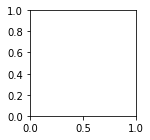

In [151]:
num=10
test_data=DATA.reshape(-1,100,100)
@interact(x=(0,60,1),y=(0,60,1))
def test(x=30,y=0):
    plt.figure(figsize=(20,4))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.axis('off')
    plt.tight_layout()
    num_plot=1
    for j in range(num):
        plt.subplot(2,num,j+1)
        plt.imshow(test_data[j+x])
    for i in range(num):
        plt.subplot(2,num,num+i+1)
        plt.imshow(test_data[i+y])
    #plt.show()

In [22]:
DATA = np.load('cube100x100_60x60_2D_simmetr_180_1.npy').reshape(3600,-1)

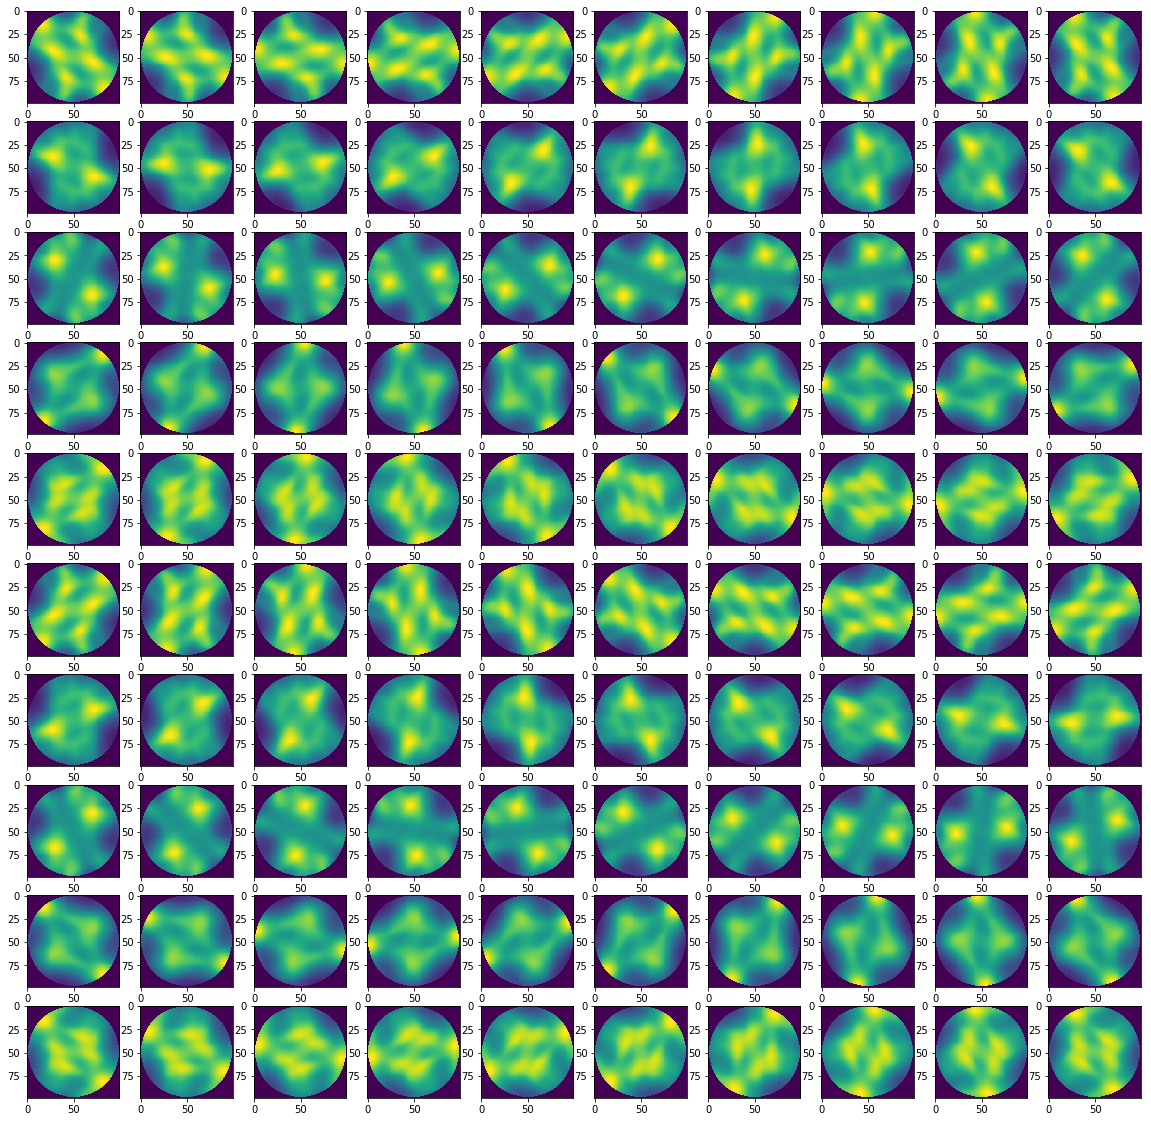

In [23]:
num=10
multipl = 6
plt.figure(figsize=(20,20))
test=DATA.reshape(multipl*num,multipl*num,-1)
for i in range(num):
    for j in range(num):
        plt.subplot(num,num,i*num+j+1)
        plt.imshow(test[multipl*i,multipl*j].reshape(99,99))

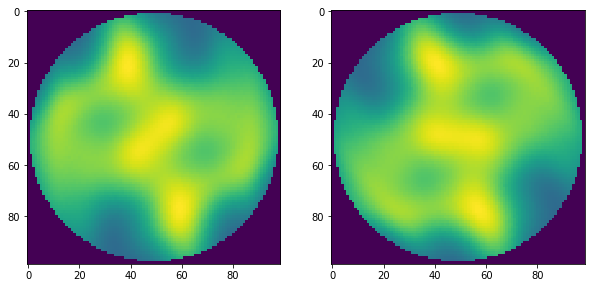

In [137]:
from skimage.transform import rotate
TST = DATA.reshape(60,60,99,99)
A = TST[12,6]
B= TST[42,36]
#B = np.flip(rotate(B,90),0)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(A)
plt.subplot(1,2,2)
plt.imshow(B)

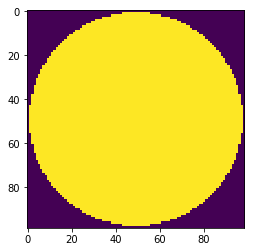

In [37]:
x, y = np.mgrid[-1.0:1.0:99j, -1.0:1.0:99j]
a = x**2+y**2
SPHERE=np.zeros(a.shape)
SPHERE[a<0.98] = 1
A = SPHERE * DATA.reshape(3600,99,99)
plt.imshow(A[0])

In [42]:
np.save('cube100x100_60x60_2D_6.npy',A.reshape(3600,-1))

In [267]:
@interact(i=(0,len(DATA)-1,1))
def test(i):
    #print(DATA[i].max())
    plt.imshow(DATA[i].reshape(100,100))

interactive(children=(IntSlider(value=799, description='i', max=1599), Output()), _dom_classes=('widget-intera…

In [11]:
from minisom import MiniSom

DATA = np.load('data_torus_60x60_2D.npy')*np.array([1,1,3])

minisom = MiniSom(60, 60, DATA.shape[1], sigma=30, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)

#minisom.random_weights_init(DATA)
minisom.pca_weights_init(DATA)
print("Training...")
minisom.train_random(DATA, 20000, verbose=True)  # random training
#som.train_batch(DATKA, 700, verbose=True)  # random training
print("\n...ready!")



Training...
 [ 20000 / 20000 ] 100% 0.03177 it/s
...ready!


In [18]:
SOM_MAP = minisom.get_weights()

import numpy as np
from mayavi.mlab import *
def test_plot3d():
    dd=SOM_MAP.reshape(-1,3)
    #dd=DATA
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    
    l = plot3d(x, y, z, np.arange(len(dd)), tube_radius=0.025, colormap='Spectral')
    #return l
test_plot3d()
show()

In [13]:
a=minisom.activation_response(DATA)

[[283.   7.   3.   2.   4.   2.   7.   8.   7.   6.]
 [  0.   0.   0.   0.   1.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  4.   2.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  6.   0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  4.   0.   0.   0.   0.   0.   2.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  3.   1.   1.   1.   0.   0.   0.   0.   0.   0.]
 [  3.   0.   0.   0.   0.   1.   1.   0.   0.   0.]]


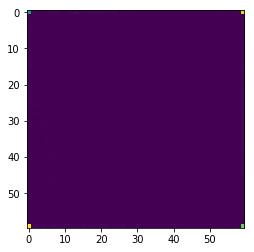

In [19]:
plt.imshow(a)
print(a[:10,:10])

In [488]:
a = minisom.get_weights().reshape(360,40000)
@interact(i=(0,360,1))
def test_func(i):
    
    plt.imshow(a[i].reshape(200,200))

ValueError: cannot reshape array of size 200 into shape (360,40000)

In [386]:
for i in range(len(DATKA)):
    print(minisom.winner(DATKA[i]))

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)

In [20]:
DATA = np.load('cube100x100_30.npy')

In [22]:
#LOOK for nearest neighboors 1D
from sklearn.neighbors import KDTree as KDTree
X = DATA#[15:50]
#X = VECTS
tree = KDTree(X)     #leaf_size=2
for _ in range(len(X)):
    dist, ind = tree.query(X[_:_+1], k=3)
    if abs(ind[0,1]-_)==1 and abs(ind[0,2]-_)==1:
        check = True
    else:
        check = False
    #print(ind)
    print(f'node {_} neighs:', ind[0,1:], check)  # indices of 3 closest neighbors
    
    #print(': ', X[ind[0,0]], X[ind[0,1]],X[ind[0,2]])
    #print(dist)

node 0 neighs: [ 1 29] False
node 1 neighs: [2 0] True
node 2 neighs: [1 3] True
node 3 neighs: [4 2] True
node 4 neighs: [3 5] True
node 5 neighs: [4 6] True
node 6 neighs: [5 7] True
node 7 neighs: [8 6] True
node 8 neighs: [7 9] True
node 9 neighs: [ 8 10] True
node 10 neighs: [ 9 11] True
node 11 neighs: [12 10] True
node 12 neighs: [13 11] True
node 13 neighs: [14 12] True
node 14 neighs: [15 13] True
node 15 neighs: [16 14] True
node 16 neighs: [17 15] True
node 17 neighs: [16 18] True
node 18 neighs: [19 17] True
node 19 neighs: [18 20] True
node 20 neighs: [19 21] True
node 21 neighs: [20 22] True
node 22 neighs: [23 21] True
node 23 neighs: [22 24] True
node 24 neighs: [23 25] True
node 25 neighs: [24 26] True
node 26 neighs: [25 27] True
node 27 neighs: [28 26] True
node 28 neighs: [29 27] True
node 29 neighs: [ 0 28] False


In [34]:
def test_neigh(node,to_check):
    if node%30==29:
        right = node+1-30
    else:
        right = node+1
        
    if node%30==0: 
        left = (node//30+1)*30-1
    else: 
        left= node-1
        
    if node>29:
        up = node -30
    else: 
        up=900+node-30
    down = node+30
    #print([right,left,up,down])
    neighs = np.sort([right,left,up,down])
    #print(neighs)
    to_check = np.sort(to_check)
    if np.all(to_check==neighs):
        return True
    else: return False
test_neigh(31,[ 1,32,0,30])

False

In [35]:
#LOOK for nearest neighboors 1D
from sklearn.neighbors import KDTree as KDTree
X = DATA#[15:50]
#X = VECTS
tree = KDTree(X)     #leaf_size=2
for _ in range(len(X)):
    dist, ind = tree.query(X[_:_+1], k=5)
    check = test_neigh(ind[0,0],ind[0,1:])
    print(f'node {_} neighs:', ind[0,1:], check)  # indices of 3 closest neighbors
    
    #print(': ', X[ind[0,0]], X[ind[0,1]],X[ind[0,2]])
    #print(dist)

node 0 neighs: [30 29  1 59] False
node 1 neighs: [31  0 30  2] False
node 2 neighs: [ 1 31 32  3] False
node 3 neighs: [  2  32  33 873] False
node 4 neighs: [ 34  33   3 874] False
node 5 neighs: [35  6 22  4] False
node 6 neighs: [  7  36   5 876] True
node 7 neighs: [ 8  6 37 36] False
node 8 neighs: [ 7  9 39 38] False
node 9 neighs: [40 10  8 39] False
node 10 neighs: [41 40  9 11] False
node 11 neighs: [42 41 12 10] False
node 12 neighs: [ 43  13  42 881] False
node 13 neighs: [ 14 883 882  12] False
node 14 neighs: [ 13  15 883 885] False
node 15 neighs: [885  14  16  45] True
node 16 neighs: [ 15 885  17 855] False
node 17 neighs: [ 16 887  18  47] True
node 18 neighs: [ 17 887 888  48] False
node 19 neighs: [889 888  18  49] False
node 20 neighs: [890  21   7   8] False
node 21 neighs: [891  22 892  20] False
node 22 neighs: [892  23  21 893] False
node 23 neighs: [893  22  24 894] False
node 24 neighs: [895 894  25  23] False
node 25 neighs: [896 895  24  26] False
node 26 n

node 213 neighs: [243 183 273 184] False
node 214 neighs: [244 184 274 213] False
node 215 neighs: [245 185 275 184] False
node 216 neighs: [246 186 276 155] False
node 217 neighs: [247 187 277 157] False
node 218 neighs: [248 188 278 158] False
node 219 neighs: [249 189 279 160] False
node 220 neighs: [250 190 280 191] False
node 221 neighs: [251 191 281 222] False
node 222 neighs: [252 192 282 191] False
node 223 neighs: [253 193 283 162] False
node 224 neighs: [254 194 284 164] False
node 225 neighs: [255 195 285 165] False
node 226 neighs: [256 196 286 317] False
node 227 neighs: [257 197 287 288] False
node 228 neighs: [258 198 288 259] False
node 229 neighs: [259 199 289 228] False
node 230 neighs: [260 290 200 199] False
node 231 neighs: [261 291 201 320] False
node 232 neighs: [262 202 292 322] False
node 233 neighs: [263 203 293 323] False
node 234 neighs: [264 294 204 325] False
node 235 neighs: [265 295 205 296] False
node 236 neighs: [266 296 206 267] False
node 237 neighs:

node 428 neighs: [429 458 459 457] False
node 429 neighs: [430 459 460 428] False
node 430 neighs: [461 431 429 460] False
node 431 neighs: [432 462 430 461] False
node 432 neighs: [433 463 431 462] False
node 433 neighs: [432 463 464 405] False
node 434 neighs: [433 464 463 435] False
node 435 neighs: [405 465 466 464] False
node 436 neighs: [466 435 467 405] False
node 437 neighs: [467 468 466 438] False
node 438 neighs: [408 437 468 469] False
node 439 neighs: [409 469 408 438] False
node 440 neighs: [470 441 410 439] True
node 441 neighs: [471 442 440 472] False
node 442 neighs: [443 472 441 412] True
node 443 neighs: [444 473 442 413] True
node 444 neighs: [443 445 474 473] False
node 445 neighs: [416 474 444 446] False
node 446 neighs: [416 476 445 475] False
node 447 neighs: [476 477 448 417] False
node 448 neighs: [477 449 478 447] False
node 449 neighs: [420 479 448 478] False
node 450 neighs: [480 479 451 509] False
node 451 neighs: [481 450 480 452] False
node 452 neighs: [4

node 830 neighs: [831 860 861 801] False
node 831 neighs: [830 801 802 772] False
node 832 neighs: [802 862 861 772] False
node 833 neighs: [803 863 864 773] False
node 834 neighs: [835 804 803 864] False
node 835 neighs: [834 864 836 804] False
node 836 neighs: [835 865 866 864] False
node 837 neighs: [838 867 868  93] False
node 838 neighs: [839 837 809  92] False
node 839 neighs: [869 838 809  91] False
node 840 neighs: [870 810 871 899] False
node 841 neighs: [842  89 840 810] False
node 842 neighs: [841 843  88 872] False
node 843 neighs: [873 844 872 842] False
node 844 neighs: [874 843 845 873] False
node 845 neighs: [846 844 875  83] False
node 846 neighs: [845 847 516 876] False
node 847 neighs: [846 877 517 817] False
node 848 neighs: [849 878 818 879] False
node 849 neighs: [850 848 879 878] False
node 850 neighs: [851 849 881 880] False
node 851 neighs: [852 882 881 850] False
node 852 neighs: [851 882 883 881] False
node 853 neighs: [854 852 884  77] False
node 854 neighs:

In [122]:
#np.save('cube100x100_30x30_2D.npy',DATA)

In [389]:
DATA = np.load('cube100x100_60x60_2D_4.npy')
import SimpSOM as sps

#Build a network 20x20 with a weights format taken from the raw_data and activate Periodic Boundary Conditions. 
net = sps.somNet(60, 60, DATA, PCI=True, PBC=True)

#Train the network for 10000 epochs and with initial learning rate of 0.01. 
net.train(0.1, 20000)

#Save the weights to file
net.save('filename_weights')

#Print a map of the network nodes and colour them according to the first feature (column number 0) of the dataset
#and then according to the distance between each node and its neighbours.
net.nodes_graph(colnum=0)
net.diff_graph()

#Project the datapoints on the new 2D network map.
#net.project(DATA, labels=labels)

#Cluster the datapoints according to the Quality Threshold algorithm.
#net.cluster(DATA, type='qthresh')	

Periodic Boundary Conditions active.
The weights will be initialised with PCA.
Training SOM... 0% 

KeyboardInterrupt: 

In [4]:
SOM_MAP = np.load('filename_weights.npy')[1:]
#look SOM_MAP
import numpy as np
from mayavi.mlab import *
def test_plot3d():
    dd=SOM_MAP.reshape(-1,3)
    #dd=DATA
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    
    l = plot3d(x, y, z, np.arange(len(dd)), tube_radius=0.025, colormap='Spectral')
    #return l
test_plot3d()
show()